# Plot CT Layer

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install tensorflow
#!pip install tensorflow --upgrade
#!pip install keras --upgrade
#!pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable


In [3]:
username = 'a1alani'

In [4]:
im = cv2.imread('/home/'+ username+ '/public/processed_data/pairs/train/pair_116/raw/116-001.png')

In [5]:
print(im.shape)

(512, 512, 3)


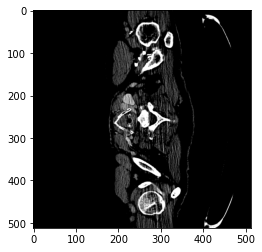

In [6]:
plt.imshow(im)

# Data Generator

In [7]:
import os
import tensorflow as tf

2023-06-06 01:18:45.906029: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 01:18:46.080424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 01:18:46.083867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 01:18:48.346287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
#!pip freeze

In [9]:
class Data_Generator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, dir_name, img_height, img_width):
        self.batch_size = batch_size
        self.dir_name = dir_name
        self.img_height = img_height
        self.img_width = img_width
        self.x, self.y = self.get_filepath()
        # self.y = #TODO: array of segmented image file paths, with matched indexes corresponding to self.x
    
    def get_filepath(self):
        files_x = []
        files_y = []
        
        for folder in sorted(os.listdir(self.dir_name)):
            if folder != ".ipynb_checkpoints":
                for file in sorted(os.listdir(f"{self.dir_name}/{folder}/raw")):
                    files_x.append(f"{self.dir_name}/{folder}/raw/{file}")
                
        for folder in sorted(os.listdir(self.dir_name)):
            if folder != ".ipynb_checkpoints":
                for file in sorted(os.listdir(f"{self.dir_name}/{folder}/gt")):
                    files_y.append(f"{self.dir_name}/{folder}/gt/{file}")
        
        return files_x[:10], files_y[:10]
    
    def __len__(self):
        return len(self.x) // self.batch_size
    
    def __getitem__(self, idx):
        id0 = idx * self.batch_size
        id1 = id0 + self.batch_size
        
        raw = []
        gt = []
        
        for i in range(id0, id1):
            raw.append(cv2.imread(self.x[i]))
            gt.append(cv2.imread(self.y[i]))
        
        raw = np.stack(raw, axis=0)
        gt = np.stack(gt, axis=0)
        
        return raw, gt

# UNET Model

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    """Creates a convoltuional block.
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        a convolution block
    """
    x = Conv2D(num_filters, 3, padding ="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding ="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    """Creates an encoding block
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        An encoding block
    """
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Creates an decoding block
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        An encoding block
    """
    x = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding="same")(inputs)
    x = Concatenate(axis=3)([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape, output_channels, filters, filters_rate, down_blocks, up_blocks):
    """Initializes a Simple Unit
    Args:
        input_shape: the size of the image
        output_channels: the number of output channels
        filters: initial filters for unet
        filters_rate: the value of how to the filters increase as you go deeper into
                    the network
        down_blocks: number one encoder blocks to create
        up_blocks: number of decoder blocks to create 
    Returns:
        a built U-Net model 
    """

    inputs = Input(input_shape)
    skip_connections = []
    filters_log = []
    prev_filters = filters

    """ Encoder """
    for i in range(down_blocks):
        if i == 0:
          s, p =  encoder_block(inputs, prev_filters)
        else:
          s, p = encoder_block(p, prev_filters)

        filters_log.append(prev_filters)
        skip_connections.append(s)

        prev_filters = int(filters_rate*prev_filters)

    """ Bridge """
    b = conv_block(p, prev_filters)

    """ Decoder """
    for i in range(up_blocks):
        if i == 0:
          d =  decoder_block(b, skip_connections[-(i+1)], filters_log[-(i+1)])
        else:
          d =  decoder_block(d, skip_connections[-(i+1)], filters_log[-(i+1)])


    """ Output """

    outputs = Conv2D(output_channels, (1,1), padding="same")(d)

    model = Model(inputs, outputs, name="U-Net")

    return model

In [11]:
model = build_unet(input_shape = (512,512,3), output_channels = 3, filters = 32, filters_rate = 2, down_blocks = 4, up_blocks = 4)

2023-06-06 01:18:51.793013: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Visualization

/home/a1alani/public/processed_data/pairs/train/pair_116/raw/116-003.png
/home/a1alani/public/processed_data/pairs/train/pair_116/gt/116-003.png


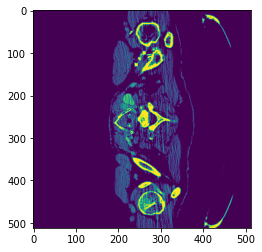

In [13]:
train_datagen = Data_Generator(79, "/home/"+ username +"/public/processed_data/pairs/train", 512, 512)
print(train_datagen.x[2])
print(train_datagen.y[2])
image_x = plt.imread(train_datagen.x[2])
image_y = plt.imread(train_datagen.y[2])
plt.imshow(image_x)
#plt.imshow(image_y)

# Training 

In [17]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.optimizers import Adam

x = tf.placeholder("float", None) 
y = tf.placeholder("float", None)

# Build the U-Net model
model = build_unet(input_shape=(512, 512, 3), output_channels=3, filters=32, filters_rate=2, down_blocks=4, up_blocks=4)

# Compile the model
# optimizer = Adam()
model.compile(loss='mse', metrics=['accuracy'])

# Create an instance of the data generator
train_datagen = Data_Generator(2, "/home/"+ username + "/public/processed_data/pairs/train", 512, 512)
test_datagen = Data_Generator(1, "/home/"+ username + "/public/processed_data/pairs/test", 512,512)


# Train the model
model.fit(train_datagen, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(test_datagen)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


2023-06-02 19:35:27.807350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-02 19:35:27.973466: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_32/moving_variance/Assign' id:1400 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_32/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_32/moving_variance, batch_normalization_32/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/10


2023-06-02 19:35:30.063194: W tensorflow/c/c_api.cc:300] Operation '{name:'batch_normalization_35/AssignMovingAvg_1/AssignSubVariableOp' id:1750 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_35/AssignMovingAvg_1/AssignSubVariableOp}} = AssignSubVariableOp[_class=["loc:@batch_normalization_35/moving_variance"], _has_manual_control_dependencies=true, dtype=DT_FLOAT](batch_normalization_35/moving_variance, batch_normalization_35/AssignMovingAvg_1/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-02 19:35:30.282609: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/batch_normalization_34/beta/rms/Assign' id:3543 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/batch_normalization_34/beta/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, 

5/5 [==============================] - 66s 12s/step - batch: 2.0000 - size: 2.0000 - loss: 0.7030 - acc: 0.4388
Epoch 2/10
5/5 [==============================] - 57s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.1143 - acc: 0.5961
Epoch 3/10
5/5 [==============================] - 57s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0621 - acc: 0.5383
Epoch 4/10
5/5 [==============================] - 55s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0395 - acc: 0.6233
Epoch 5/10
5/5 [==============================] - 55s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0354 - acc: 0.4387
Epoch 6/10
5/5 [==============================] - 56s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0178 - acc: 0.4575
Epoch 7/10
5/5 [==============================] - 56s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0194 - acc: 0.4093
Epoch 8/10
5/5 [==============================] - 57s 11s/step - batch: 2.0000 - size: 2.0000 - loss: 0.0197 - acc: 0.5038
Epoch 9/10
5/5 [===========

/home/a1alani/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-02 19:45:00.050688: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:1819 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/conv2d_37_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Test Loss: 5.945160388946533
Test Accuracy: 0.6802254


In [18]:
model.evaluate(test_datagen)

[5.945160388946533, 0.6802254]

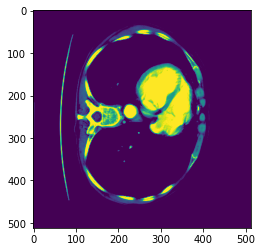

In [19]:
image = plt.imread(test_datagen.x[9])
plt.imshow(image)

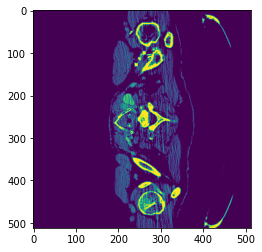

In [20]:
image2 = plt.imread(train_datagen.x[5])
plt.imshow(image2)

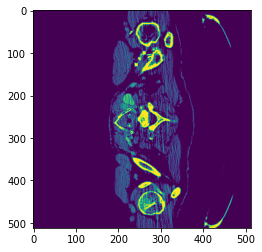

In [21]:
image3 = "/home/a1alani/public/processed_data/pairs/test/pair_402/raw/402-001.png"
plt.imread(image3)
image3 = np.expand_dims(image3, axis=0)
image3 = np.resize(image3, (1, 512, 512, 3))
image3.shape
plt.imshow(image2)

In [22]:
#image = np.expand_dims(image, axis=0)
#image = np.expand_dims(image, axis=image.ndim)
#image = np.resize(image, (1, 512, 512, 3))
image = np.expand_dims(image, axis=0)
image = np.resize(image, (1, 512, 512, 3))


In [23]:
image2 = np.expand_dims(image, axis=0)
image2 = np.resize(image, (1, 512, 512, 3))
image2.shape

(1, 512, 512, 3)

In [24]:
image.shape

(1, 512, 512, 3)

In [25]:
prediction = model.predict(image2)
print(prediction)

/home/a1alani/.local/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-02 19:45:43.978668: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_37/BiasAdd' id:1772 op device:{requested: '', assigned: ''} def:{{{node conv2d_37/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](conv2d_37/Conv2D, conv2d_37/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[[[[ 2.1092715e-02  2.8544474e-02 -3.3979621e-03]
   [ 3.9611258e-02 -8.5417815e-03 -2.6646011e-02]
   [ 3.8501434e-02  3.4411360e-02  4.6374239e-03]
   ...
   [ 7.8100078e-02  1.0710787e-02  8.7361000e-03]
   [ 9.6406993e-03  1.0434337e-02  1.3784185e-02]
   [ 5.6283213e-02  7.5768307e-02  1.2947306e-02]]

  [[-6.8085957e-03 -1.5703522e-02 -2.4872683e-02]
   [ 7.3583815e-03 -2.1194868e-02  5.0703138e-03]
   [-2.4052333e-02 -2.4167515e-02 -4.7707196e-02]
   ...
   [-5.0360803e-02 -3.1227577e-02  2.1419398e-02]
   [-3.2369606e-02 -2.1005109e-02 -2.1442238e-02]
   [-8.2205176e-02  3.7351083e-02 -1.9354060e-02]]

  [[ 4.7637306e-02 -4.1663628e-03 -1.4414901e-02]
   [ 5.2310236e-02  4.5793280e-03 -5.1227696e-02]
   [ 1.2397895e-02 -5.1452190e-02  7.5361542e-03]
   ...
   [ 3.3143349e-02 -2.4582788e-02 -4.2223461e-02]
   [-2.6886988e-02 -4.4426627e-02  2.7240593e-02]
   [ 1.3166694e-02  3.5079833e-02 -9.5508993e-05]]

  ...

  [[-3.2282565e-03  9.8214485e-03 -2.2749618e-02]
   [ 8.1843641e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


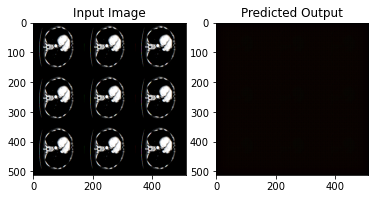

In [26]:
plt.subplot(1, 2, 1)
plt.imshow(image2.squeeze())
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(prediction.squeeze())
plt.title('Predicted Output')

plt.show()

# Test Data Prediction Accuracy

In [27]:
!mkdir -p saved_model

In [28]:
model.save('saved_model/ali_model')